# Importing the dataset

In [1]:
import pandas as pd

merged_df = pd.read_pickle("Features.pkl")

In [2]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2065 entries, 0 to 2089
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   text                  2065 non-null   object 
 1   label                 2065 non-null   int32  
 2   readability_score     2065 non-null   float64
 3   syntactic_complexity  2065 non-null   float64
 4   lexical_richness      2065 non-null   float64
 5   sentiment_score       2065 non-null   float64
 6   burstiness            2065 non-null   float64
 7   semantic_coherence    2064 non-null   float64
 8   perplexity            2064 non-null   float64
 9   unique_bigrams        2065 non-null   int64  
 10  unique_trigrams       2065 non-null   int64  
dtypes: float64(7), int32(1), int64(2), object(1)
memory usage: 185.5+ KB


In [3]:
values_missing = merged_df.isnull().sum()
print(values_missing)

text                    0
label                   0
readability_score       0
syntactic_complexity    0
lexical_richness        0
sentiment_score         0
burstiness              0
semantic_coherence      1
perplexity              1
unique_bigrams          0
unique_trigrams         0
dtype: int64


In [4]:
merged_df.shape

(2065, 11)

In [5]:
merged_df = merged_df.dropna(subset=['perplexity', 'semantic_coherence'])

In [6]:
merged_df.shape

(2064, 11)

# Exploratory Data Analysis

## 1. Numerical Feature Distribution

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

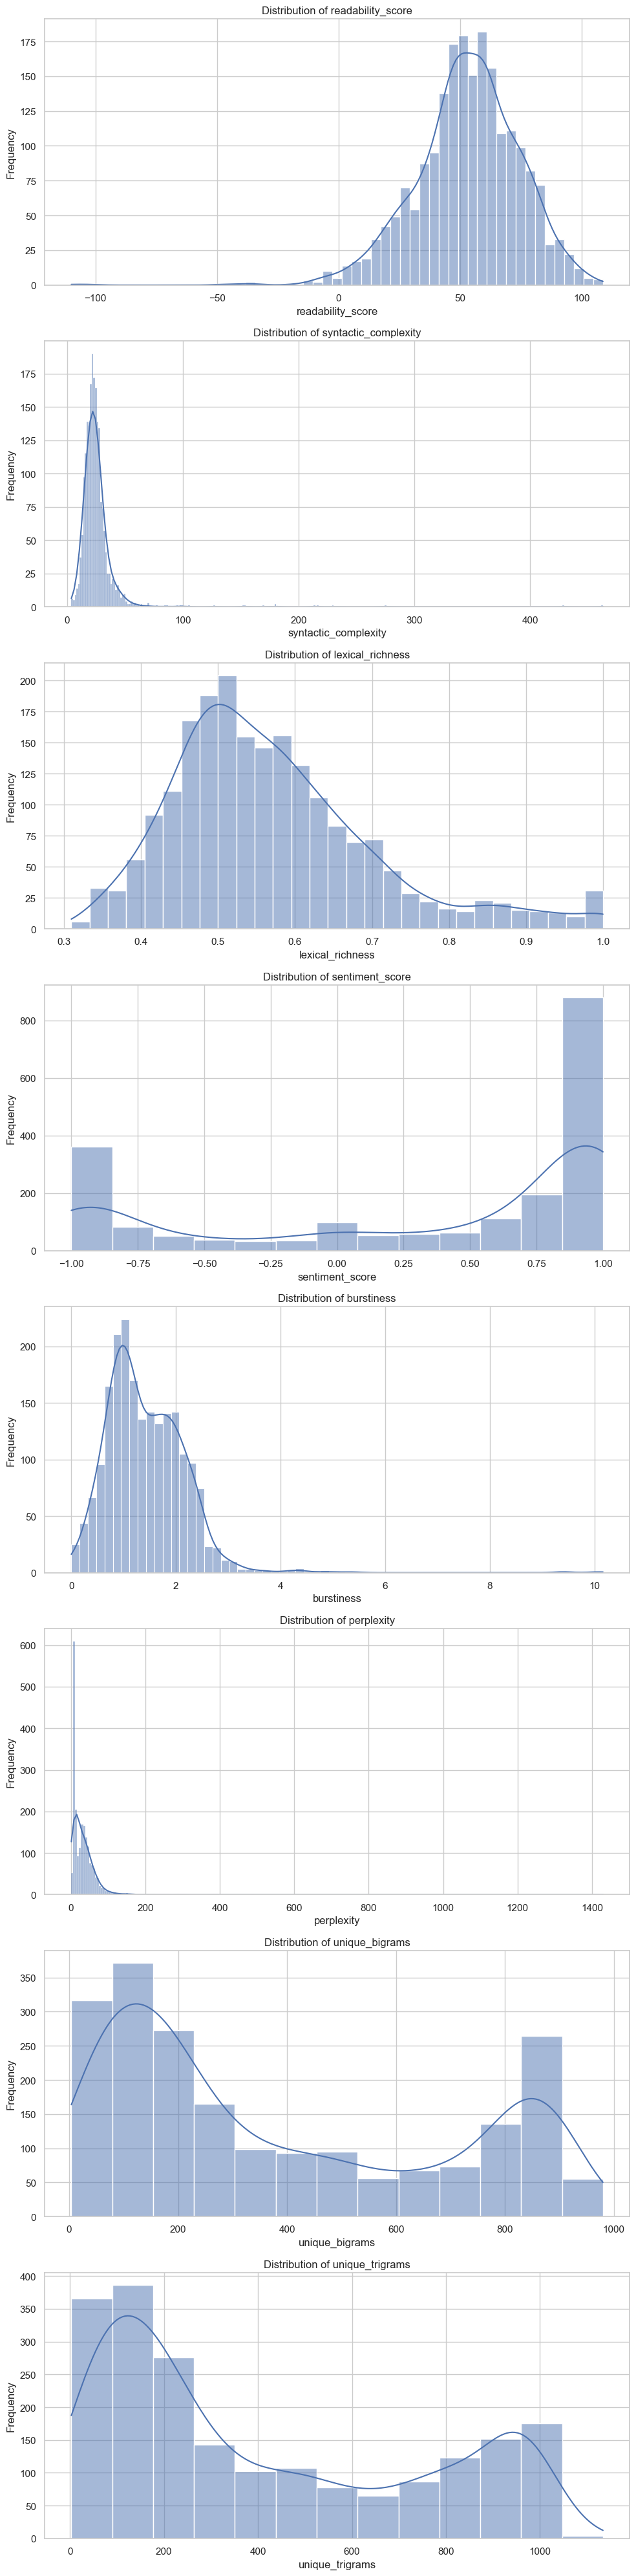

In [8]:
def plot_numerical_feature_distribution(df, feature_names):
    fig, axs = plt.subplots(len(feature_names), 1, figsize=(10, 5 * len(feature_names)))
    if len(feature_names) == 1:  
        axs = [axs]
    for i, feature_name in enumerate(feature_names):
        sns.histplot(df[feature_name], kde=True, ax=axs[i])
        axs[i].set_title(f'Distribution of {feature_name}')
        axs[i].set_xlabel(feature_name)
        axs[i].set_ylabel('Frequency')
    plt.tight_layout()
    plt.show()

plot_numerical_feature_distribution(merged_df, ['readability_score', 'syntactic_complexity', 'lexical_richness', 
                                                'sentiment_score', 'burstiness', 'perplexity','unique_bigrams',
                                                'unique_trigrams'])

In [9]:
numerical_features = ['readability_score', 'syntactic_complexity', 'lexical_richness', 'sentiment_score', 'burstiness', 'perplexity',
                      'unique_bigrams','unique_trigrams']

for feature in numerical_features:
    skewness = merged_df[feature].skew()
    kurtosis = merged_df[feature].kurtosis()
    print(f"{feature} - Skewness: {skewness}, Kurtosis: {kurtosis}")

readability_score - Skewness: -0.7583346038810577, Kurtosis: 3.200000811838658
syntactic_complexity - Skewness: 12.388383272993204, Kurtosis: 218.81010532876053
lexical_richness - Skewness: 1.0441357678953438, Kurtosis: 1.1772133830571434
sentiment_score - Skewness: -0.7143711763572149, Kurtosis: -1.1691685784466788
burstiness - Skewness: 2.769794901957019, Kurtosis: 24.049744421100826
perplexity - Skewness: 16.904321657827882, Kurtosis: 409.5866225847015
unique_bigrams - Skewness: 0.5403494417938969, Kurtosis: -1.2514460074127332
unique_trigrams - Skewness: 0.5841646186907211, Kurtosis: -1.1739198843085037


### Insights from above:
- Syntactic Complexity and Perplexity have outliers with sharp peaks, showing non-normality.
- Burstiness exhibits noticeable outliers and a relatively sharp peak, though less extreme than the above features.
- Lexical Richness, Sentiment Score, Unique Bigrams, and Unique Trigrams show distributions that are slightly asymmetrical, closer to normal but with some deviations.

## 2. Class Imbalance Check

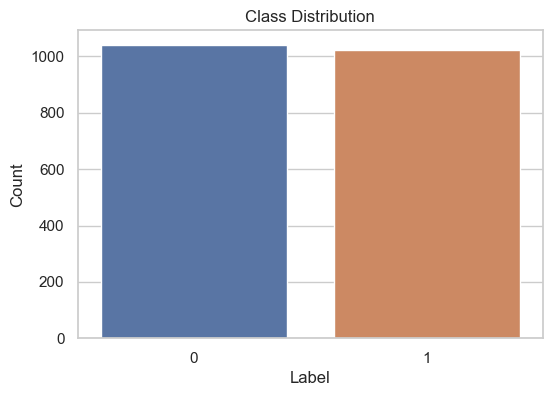

In [10]:
def plot_class_distribution(df, label_column):
    plt.figure(figsize=(6, 4))
    sns.countplot(x=label_column, data=df)
    plt.title('Class Distribution')
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.show()

plot_class_distribution(merged_df, 'label')

### Insights from above:
0 - Human-Written Text and 1 - AI-generated text, they don't appear to have any class imbalance since the data was prepared that way. 

## 4. Mann-Whitney U test between AI-Generated and Human-Written classes

In [11]:
from scipy.stats import mannwhitneyu

# Function to perform Mann-Whitney U test and calculate effect size
def mann_whitney_test(df, features, label_col='label'):
    results = []
    for feature in features:
        group1 = df[df[label_col] == 0][feature]
        group2 = df[df[label_col] == 1][feature] 
        # Performing Mann-Whitney U test
        stat, p = mannwhitneyu(group1, group2)
        # Calculating effect size - using the rank-biserial correlation as the effect size
        # Effect size (r) = 1 - (2U / (n1*n2))
        n1, n2 = len(group1), len(group2)
        U = min(stat, n1*n2 - stat)  # Using the smallest U value
        effect_size = 1 - (2*U / (n1*n2))
        
        results.append({'Feature': feature, 'p-value': p, 'Effect Size': effect_size})
    
    return pd.DataFrame(results)

# List of features to test
features = ['readability_score', 'syntactic_complexity', 'lexical_richness', 
            'sentiment_score', 'burstiness', 'perplexity', 
            'unique_bigrams', 'unique_trigrams', 'semantic_coherence']

# Performing tests
results_df = mann_whitney_test(merged_df, features)

# Sorting results
results_df.sort_values(by='p-value', inplace=True)

print(results_df)

                Feature        p-value  Effect Size
5            perplexity  3.145914e-277     0.904502
7       unique_trigrams  1.402511e-103     0.549439
6        unique_bigrams   3.421271e-93     0.520609
4            burstiness   3.304732e-68     0.443701
0     readability_score   5.403000e-43     0.349466
1  syntactic_complexity   6.357427e-27     0.273138
3       sentiment_score   1.948478e-10     0.161827
2      lexical_richness   2.074239e-10     0.161586
8    semantic_coherence   6.144800e-04     0.019747


### Insights from above:
The results shows significant differences between human-written and AI-generated text across all tested features, as all features have p-values significantly below the common significance threshold (0.05) meaning they are statistically significant. The effect size tells us the magnitude of these differences. Perplexity with an effect size of 0.904502, shows a very strong difference between the groups suggesting that it's an important feature. On the other hand, semantic_coherence, with an effect size of 0.019747, indicates a very weak relationship between the groups, suggesting it has minimal discriminatory power in this context.

## 5. Multicollinearity Check

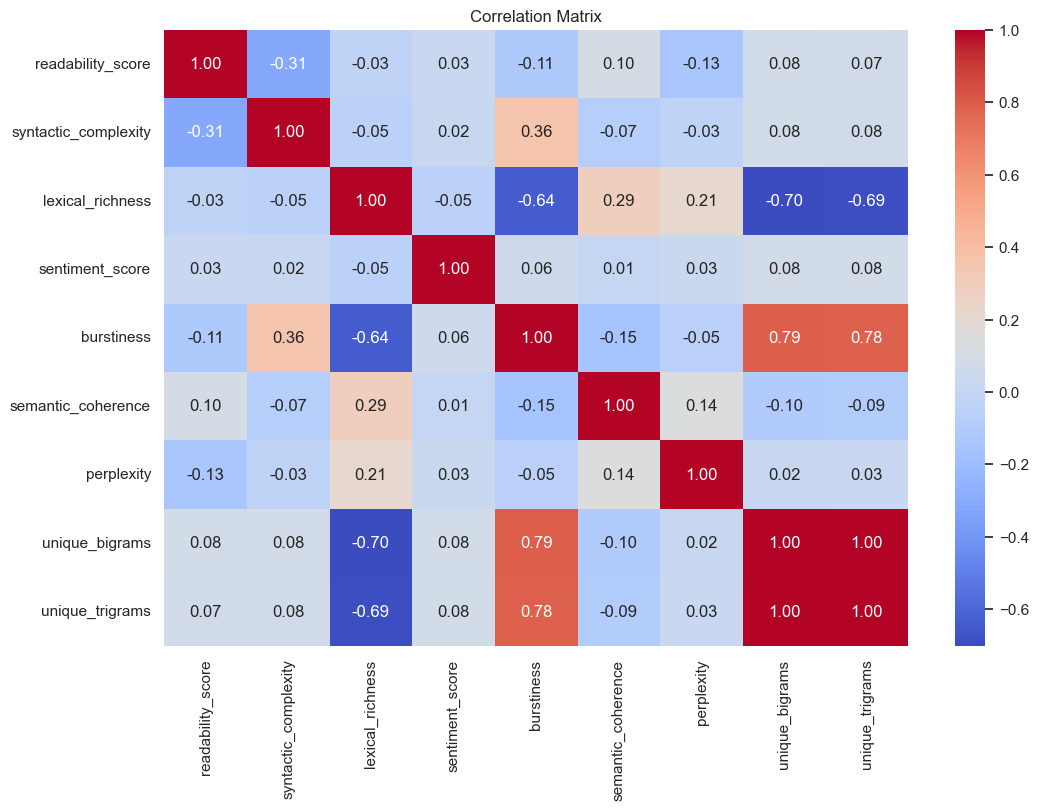

In [12]:
features_df = merged_df.drop(['label', 'text'], axis=1, errors='ignore')
corr = features_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

### Insights from above:
Unique Bigrams and Trigrams have very high relation of 1, meaning they are essentially the same, hence I will be dropping unique_bigrams here. Keeping unqiue_trigrams over unique_bigrams as from comparing the effect size from Mann-Whitney U test we saw that the unqiue_trigrams has a better effect size.

In [13]:
del merged_df['unique_bigrams']

## 6. Outliers

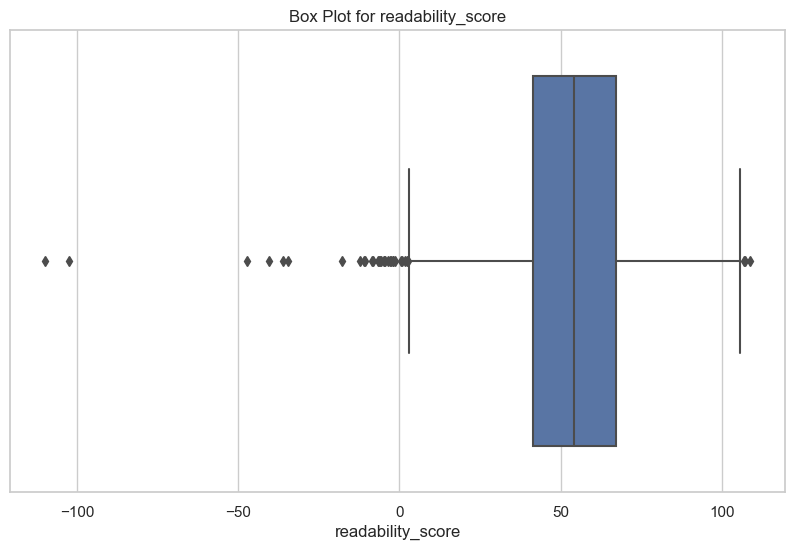

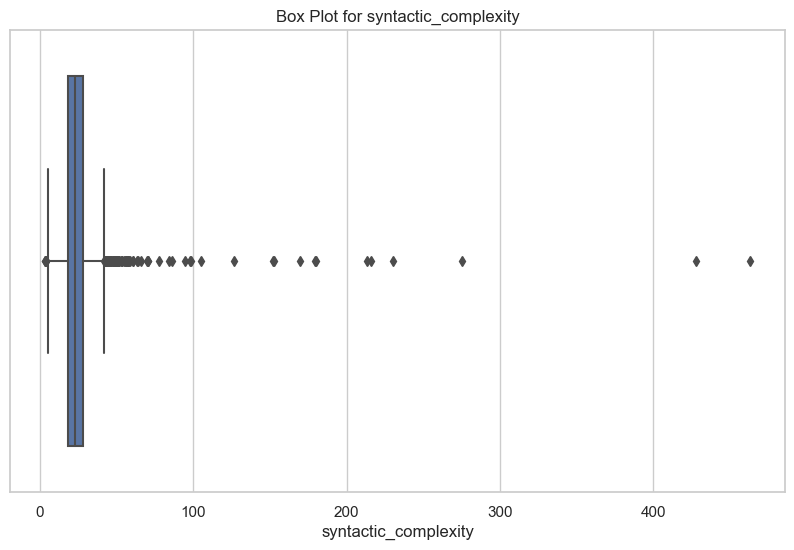

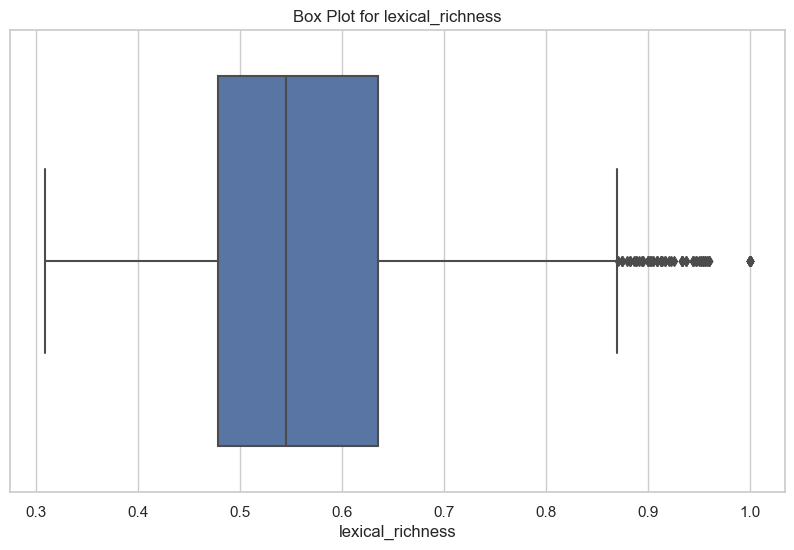

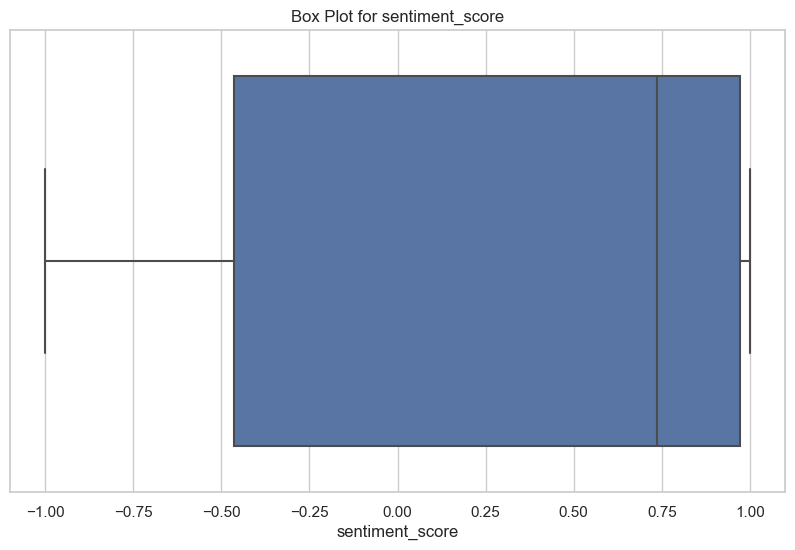

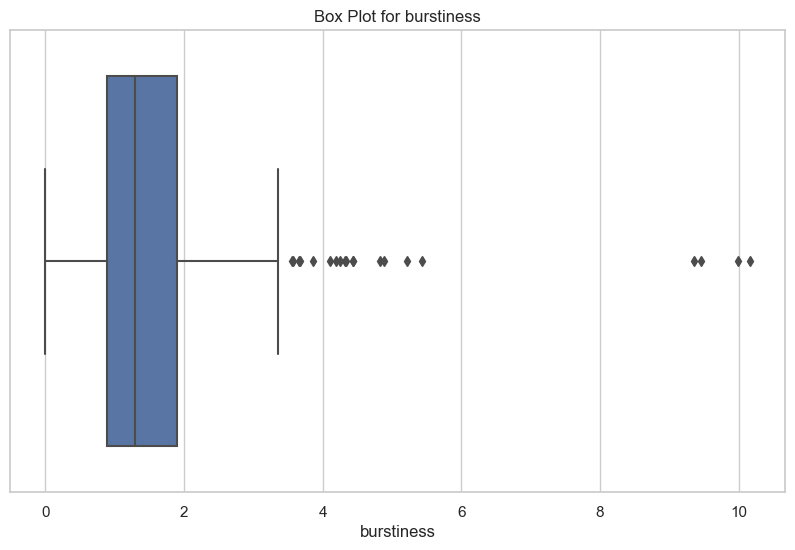

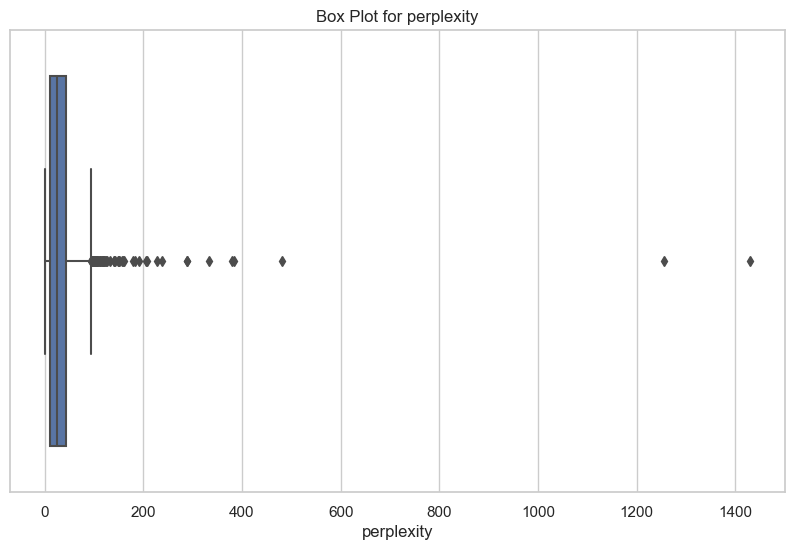

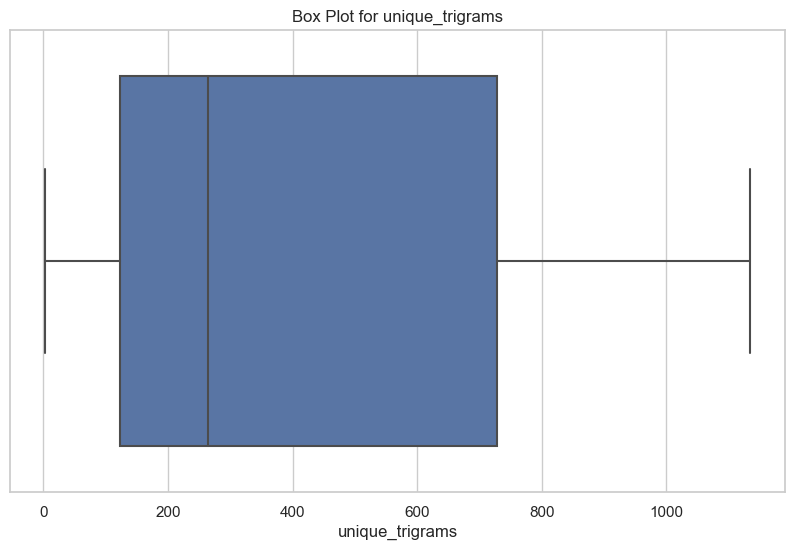

In [14]:
numerical_features = ['readability_score', 'syntactic_complexity', 'lexical_richness', 'sentiment_score', 'burstiness', 'perplexity', 'unique_trigrams']

for feature in numerical_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=merged_df[feature])
    plt.title(f'Box Plot for {feature}')
    plt.show()

### Insights from above:
Although we can see outliers, I won't be removing them to since these are based on the text features and removing any outliers could potentially lead to loss of data.

In [15]:
merged_df.to_pickle("Final_Features.pkl")